# Dynamic Data Analysis

We begin by importing all the necessary libraries

In [1]:
# For preprocessing
import os
from glob import glob
import statistics
import json

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline

# For training
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import time

# For testing
from sklearn.metrics import confusion_matrix

# For exporting
import pickle

# Analysis

We'll begin our analysis by making a list of all the files that are available to us for analysis

In [2]:
malware_dir_1 = "../../Dynamic_Analysis_Data_Part1/Malware"
benign_dir_1 = "../../Dynamic_Analysis_Data_Part1/Benign"
malware_dir_2 = "../../Dynamic_Analysis_Data_Part2/Malware"
benign_dir_2 = "../../Dynamic_Analysis_Data_Part2/Benign"
malwares = []
benigns = []

for malware in glob(os.path.join(malware_dir_1, "*")):
    malwares += glob(os.path.join(malware, "*"))
    
benigns = glob(os.path.join(benign_dir_1, "*"))

for malware in glob(os.path.join(malware_dir_2, "*")):
    malwares += glob(os.path.join(malware, "*"))
    
benigns = glob(os.path.join(benign_dir_2, "*"))

Now, lets have a look at our features to get a better understand of our data.

In this case, we were able to get incredible results using just one feature - Severity.

Severity is a measure (on a scale of 8) of how critical the code section that is being executed is.

In general, malwares will try to access more critical code and thus attain a higher severity rate.

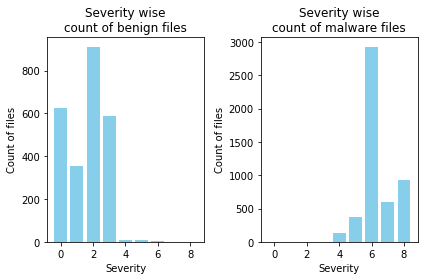

In [3]:
def max_severity(f_path):
    f = open(f_path, "r", errors="ignore", encoding="utf8")
    f = json.load(f)
    severities = [0]
    for each in f["signatures"]:
        severities.append(each["severity"])
    return max(severities)

benign_vals = []
malware_vals = []

for file in benigns:
    benign_vals.append(max_severity(file))

for file in malwares:
    malware_vals.append(max_severity(file))

# creating the bar plot 
plt.subplot(1, 2, 1)
plt.bar(np.arange(9),
        [benign_vals.count(i) for i in range(9)],
        color ='skyblue') 
plt.ylabel("Count of files")
plt.xlabel("Severity")
plt.title("Severity wise\ncount of benign files")

plt.subplot(1, 2, 2)
plt.bar(np.arange(9),
        [malware_vals.count(i) for i in range(9)],
        color ='skyblue') 
plt.ylabel("Count of files")
plt.xlabel("Severity")
plt.title("Severity wise\ncount of malware files")

plt.tight_layout()
plt.show() 

Clearly, severity is a great feature to determine whether the given code is malicious or not.

Let's try to see if we can get decent results using just this one particular feature.

# Training

We will use the function we defined above to extract features.

For the sake of abstract and future use, we will create a wrapper function that for now, only calls that one function.

In [4]:
def extract_features(f_path):
    return [max_severity(f_path)]

Next, we write the code to send files from our dataset for feature extraction

In [5]:
# Number of samples to take of each type. Set as a negative to use entire dataset
limit = -1

x = []
y = []

i = 0
for file in benigns:
    x.append(extract_features(file))
    y.append(0)
    i += 1
    if i == limit:
        break

i = 0
for file in malwares:
    x.append(extract_features(file))
    y.append(1)
    i += 1
    if i == limit:
        break

x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.25,
                                                    random_state=42)

Now, onto the actual trainning.

We use Random Forest Classifier as the data is highly threshold based. Forest classifiers give good results on such data.

In [6]:
cls = RandomForestClassifier()
start = time.time()
cls.fit(x_train, y_train)
stop = time.time()
print(f"Training time: {stop - start} seconds")

Training time: 0.2561626434326172 seconds


# Testing

Now that our model is trained, we can test it's accuracy and speed

In [7]:
start = time.time()
accuracy = str(cls.score(x_test, y_test))
stop = time.time()

y_pred = cls.predict(x_test)
tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()

precision = tp/(tp + fp)
recall = tp/(tp + fn)
fscore =  2*((precision*recall)/(precision+recall))

print("Accuracy: " + accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F-score: ", fscore)
print(f"Testing time: {(stop - start)} seconds for {len(y_test)} predictions")

Accuracy: 0.9967811158798283
Precision:  0.9923780487804879
Recall:  0.9984662576687117
F-score:  0.9954128440366974
Testing time: 0.027327775955200195 seconds for 1864 predictions


Clearly, our model is able to give us incredible accuracy and speed with just one feature.

This is the most ideal possible case for a ML algorithm.

# Export

In [8]:
pickle.dump(cls, open("./dynamic_model", 'wb'))